# MushCamp EfficientNetB7

### Import Library

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from efficientnet.tfkeras import EfficientNetB7

### Load Data

In [2]:
trainPath = r'dataset\dataSplit\train'
validationPath = r'dataset\dataSplit\val'
testPath = r'dataset\dataSplit\test'

In [3]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

### Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.45,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

#Train
train_generator = train_datagen.flow_from_directory(
                                            trainPath,
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                            )

#Validation
validation_generator=val_datagen.flow_from_directory(
                                            validationPath,
                                                    target_size=(224,224),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

#Test
test_generator=val_datagen.flow_from_directory(
                                            testPath,
                                                    target_size=(224,224),
                                                    batch_size=64,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

Found 2232 images belonging to 9 classes.
Found 279 images belonging to 9 classes.
Found 288 images belonging to 9 classes.


##### CallBacks

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.4, patience=3, 
                                    verbose=1, mode='min', 
                                    min_delta=0.0001, min_lr=0,
                                    restore_best_weights=True)

##### Load Model EfficientNetB7

In [6]:
pre_trained_model_B7 = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg'
)

##### Layering EfficientNetB7

In [7]:
# for layer in pre_trained_model_B7.layers:
#     layer.trainable = False


# last_layer = pre_trained_model_B7.get_layer('avg_pool')
# last_output = last_layer.output


# x = layers.Flatten()(last_output)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense (9, activation='softmax')(x)

# model_B7 = Model( pre_trained_model_B7.input, x) 

# model_B7.compile(optimizer = 'adam', 
#               loss = 'categorical_crossentropy', 
#               metrics = ['accuracy'])

In [8]:
for layer in pre_trained_model_B7.layers:
    layer.trainable = False

last_layer = pre_trained_model_B7.get_layer('avg_pool')
last_output = last_layer.output

In [9]:
# model_B7 = tf.keras.Sequential()
# model_B7.add(last_output)
# model_B7.add(layers.Flatten())
# model_B7.add(layers.Dense(256, activation='relu'))
# model_B7.add(layers.Dense(128, activation='relu'))
# model_B7.add(layers.Dropout(0.5))
# model_B7.add(layers.Dense(9, activation='softmax'))

x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense (9, activation='softmax')(x)

model_B7 = Model( pre_trained_model_B7.input, x) 

In [10]:
model_B7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# model_B7.summary()

##### Training Model with EfficeintNetB7

In [12]:
history = model_B7.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50,
            callbacks=[reduceLROnPlat])

Epoch 1/50


c:\Users\kandika\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 281s 7s/step - accuracy: 0.1962 - loss: 2.0975 - val_accuracy: 0.5197 - val_loss: 1.4178 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step - accuracy: 0.4585 - loss: 1.5299 - val_accuracy: 0.5520 - val_loss: 1.1483 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 252s 7s/step - accuracy: 0.5367 - loss: 1.3063 - val_accuracy: 0.7204 - val_loss: 0.9142 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 252s 7s/step - accuracy: 0.5953 - loss: 1.1464 - val_accuracy: 0.7384 - val_loss: 0.8280 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.6410 - loss: 1.0061 - val_accuracy: 0.6487 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - accuracy: 0.6252 - loss: 1.0376 - val_accuracy: 0.7670 - val_loss: 0.7310 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 251s 7s/step - accuracy: 0.6760 - loss: 0.9430 - val_accuracy: 0.77

##### Eval Model using Data Testing

In [13]:
B7_eval = model_B7.evaluate(test_generator,verbose=0)
B7_acc = round(B7_eval[1],2) * 100
B7_acc

84.0

##### Save Model

In [14]:
model_B7.save('saved-models/model_EfficientNetB7.h5')

##### Confusion Matrix

In [15]:
import os

class_names = os.listdir(trainPath)
print('All category : ',class_names)

All category :  ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [17]:
y_test = []
y_pred = []

for i in range(len(test_generator)) :
    x,y = next(test_generator)
    for j in range(len(y)) :
        y_test.append(class_names[tf.argmax(y[j])])
        y_pred.append(class_names[np.argmax(model_B7.predict(x[j][None,...],verbose=0))])

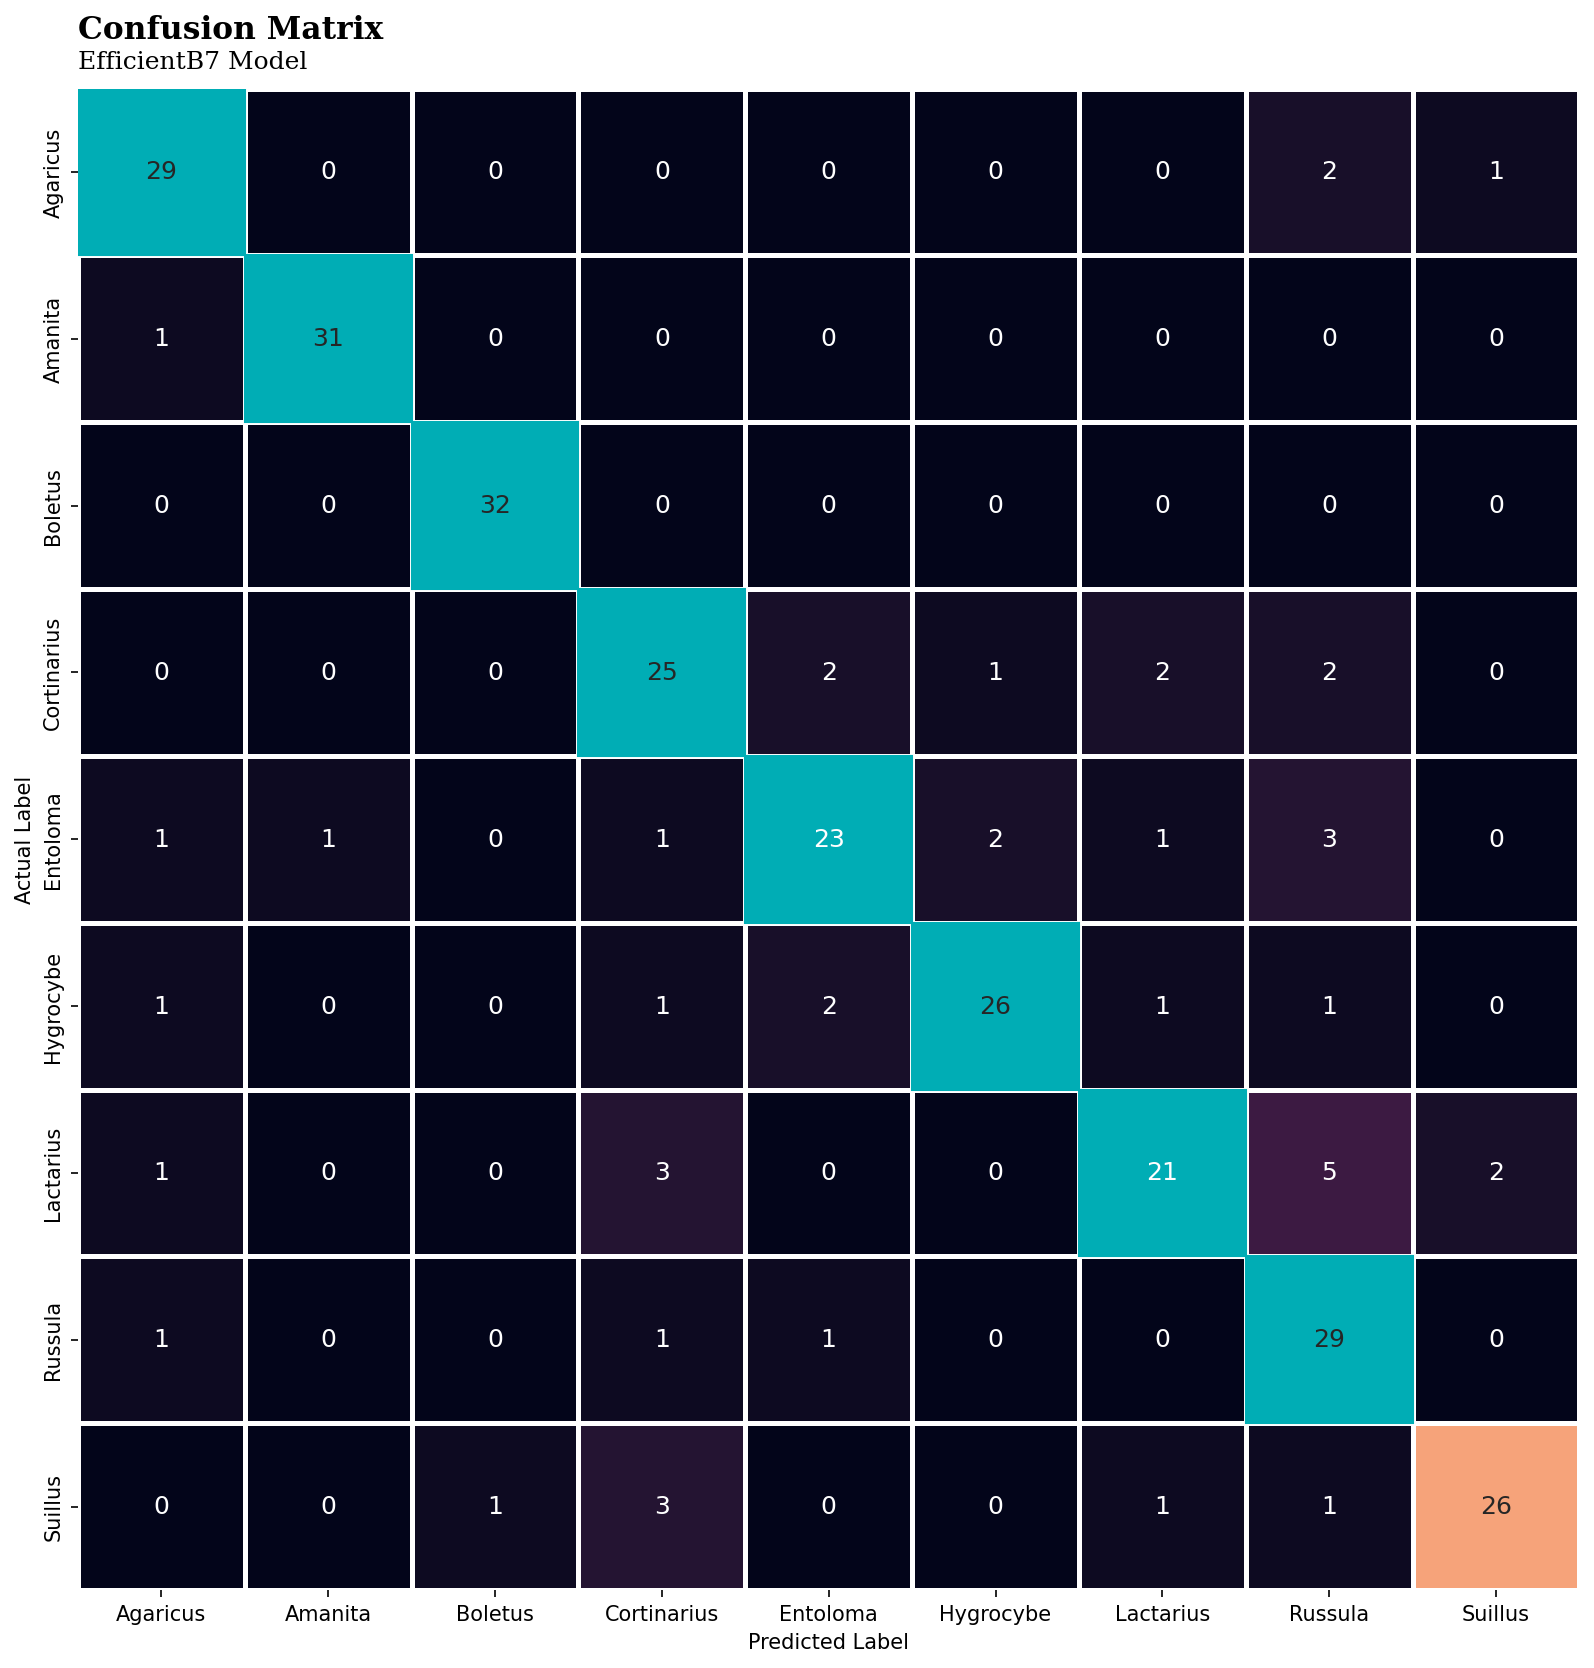

In [18]:
fig, ax = plt.subplots(figsize=(18, 13),dpi=150)
cm = confusion_matrix(y_test, y_pred)

colors = ["#393E46","#393E46"]

ax.text(0,-0.3,'Confusion Matrix ',fontfamily='serif',fontsize=15,fontweight='bold')
ax.text(0,-0.12,'EfficientB7 Model',fontfamily='serif',fontsize=12,fontweight='light')
sns.heatmap(ax=ax, data=cm,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=1.5, annot=True, 
            annot_kws={"fontsize":12},fmt='')

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

ax.set_ylabel("Actual Label",fontsize=10)
ax.set_xlabel("Predicted Label",fontsize=10)

from matplotlib.patches import Rectangle
for i in range(0,8):
    ax.add_patch(Rectangle((i, i), 1, 1, fill=True,color='#00ADB5'))

plt.show()